<a href="https://colab.research.google.com/github/QasimWani/simple-transformer/blob/main/mlp/image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datasets import load_dataset, Dataset
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import pandas
import matplotlib.pyplot as plt

from diffusers.utils import make_image_grid
from PIL import Image, ImageDraw, ImageFont

from torch.utils.data import DataLoader, TensorDataset

import sklearn
import sklearn.metrics as metrics
from collections import defaultdict
from tqdm import tqdm
from functools import partial
from diffusers.utils import make_image_grid
from PIL import ImageDraw, ImageFont

print(torch.cuda.is_available())

True


In [2]:
# Step 1 - inspect dataset
ds = load_dataset("uoft-cs/cifar10")

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

# Step 2 - Define transform
base_transform = transforms.Compose([
    transforms.ToTensor(),  # (H, W, C) PIL → (C, H, W) float32 [0,1]
    # transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD), # Remove for testing purposes, so easier to visualize errors
])

# aug_transform = transforms.Compose([ # Only used for training
#     transforms.ToTensor(),
#     transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(15),
# ])

# Step 3 - Wrap in dataset class
def transform_batch(batch, transform):
    imgs = [transform(img) for img in batch['img']]
    labels = batch['label']
    return {'pixel_values': imgs, 'labels': labels}


ds_val = ds['test'].with_transform(partial(transform_batch, transform=base_transform))
ds_train = ds['train'].with_transform(partial(transform_batch, transform=base_transform))

# Step 4 - Torch DataLoader
train_loader = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
class CorruptedDataset(torch.utils.data.Dataset):
    """
    Dataset wrapper that corrupts CIFAR10 images in two ways:
    1. Zero-out features (null_samples): Completely zeros out image tensors
    2. Duplicate features (duplicate_samples): Creates duplicates with added noise

    Parameters:
    -----------
    original_dataset: The original dataset to corrupt
    null_samples: float, proportion of samples to zero out (0.0 to 1.0)
    duplicate_samples: float, proportion of samples to duplicate with noise (0.0 to 1.0)

    Note: null_samples + duplicate_samples should be <= 1.0
    """

    def __init__(self, original_dataset, null_samples=0.0, duplicate_samples=0.0):
        self.data = original_dataset
        self.original_size = len(original_dataset)

        # Validate parameters
        if null_samples < 0 or null_samples > 1:
            raise ValueError("null_samples must be between 0 and 1")
        if duplicate_samples < 0 or duplicate_samples > 1:
            raise ValueError("duplicate_samples must be between 0 and 1")
        if null_samples + duplicate_samples > 1:
            raise ValueError("null_samples + duplicate_samples must be <= 1")

        # Calculate number of samples for each corruption type
        self.num_null = int(self.original_size * null_samples)
        self.num_duplicates = int(self.original_size * duplicate_samples)
        self.num_clean = self.original_size - self.num_null - self.num_duplicates

        # Randomly select indices for null samples and samples to duplicate
        all_indices = torch.arange(self.original_size)
        # np.random.shuffle(all_indices)
        all_indices = all_indices[torch.randperm(self.original_size)]

        self.null_indices = set(all_indices[:self.num_null].tolist())
        self.duplicate_source_indices = all_indices[self.num_null:self.num_null + self.num_duplicates]

        # Store noise levels for duplicates (between 1e-3 and 10)
        low, high = -3.0, 1
        log_uniform_number = torch.empty(self.num_duplicates).uniform_(low, high)  # uniform in [-3, 10]
        self.noise_levels = 10 ** log_uniform_number


        print(f"Dataset composition:")
        print(f"  - Clean samples: {self.num_clean}")
        print(f"  - Null samples: {self.num_null}")
        print(f"  - Duplicate samples: {self.num_duplicates}")
        print(f"  - Min and max noise level: Min {round(self.noise_levels.min().item(), 3)}\tMax {round(self.noise_levels.max().item(), 3)}")
        print(f"  - Total samples: {self.__len__()}")

    def __len__(self):
        # Original size + duplicates
        return self.original_size + self.num_duplicates

    def __getitem__(self, idx):
        if idx < self.original_size:
            # Original sample (could be clean or nulled)
            sample = self.data[idx]

            # Unpack
            img = sample['pixel_values'] if isinstance(sample, dict) else sample[0]
            label = sample['labels'] if isinstance(sample, dict) else sample[1]

            # Check if this should be a null sample
            if idx in self.null_indices:
                # Zero out the image
                img = torch.zeros_like(img)

        else:
            # Duplicate sample with noise
            duplicate_idx = idx - self.original_size
            source_idx = self.duplicate_source_indices[duplicate_idx].item()
            sample = self.data[source_idx]

            # Unpack
            img = sample['pixel_values'] if isinstance(sample, dict) else sample[0]
            label = sample['labels'] if isinstance(sample, dict) else sample[1]

            # Add noise (between 1e-3 and 1e1)
            noise_level = self.noise_levels[duplicate_idx]
            noise = torch.randn_like(img) * noise_level
            img = img + noise

        return {'pixel_values': img, 'labels': label} if isinstance(sample, dict) else (img, label)


def create_corrupted_dataloader(dataloader, null_samples: float, duplicate_samples: float):
    """
    Create a corrupted version of the dataloader.

    Parameters:
    -----------
    dataloader: Original DataLoader
    null_samples: float, proportion of samples to zero out (0.0 to 1.0)
    duplicate_samples: float, proportion of samples to duplicate with noise (0.0 to 1.0)

    Returns:
    --------
    DataLoader with corrupted dataset
    """
    corrupted_dataset = CorruptedDataset(
        dataloader.dataset,
        null_samples=null_samples,
        duplicate_samples=duplicate_samples
    )

    return DataLoader(
        corrupted_dataset,
        batch_size=dataloader.batch_size,
        shuffle=isinstance(dataloader.sampler, torch.utils.data.sampler.RandomSampler),
        num_workers=dataloader.num_workers,
        pin_memory=dataloader.pin_memory,
        drop_last=dataloader.drop_last
    )

In [4]:
class Network(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 32 x 32 -> 32 x 32
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2), # 32 x 32 -> 16 x 16

        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 16 x 16 -> 16 x 16
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2), # 16 x 16 -> 8 x 8

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 8 x 8 -> 8 x 8
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2) # 8 x 8 -> 4 x 4
    )

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),  # output shape: (N, 64, 1, 1)
        nn.Flatten(), # (N, 64)
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(64, num_classes) # logits
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.feature_extractor(x)
    logits = self.classifier(x)
    return logits

# Basic model training
def train_one_epoch(train_dataloader, test_dataloader, model, criterion, optimizer):
  model.train()
  total_loss = 0.0
  for batch in tqdm(train_dataloader):
    torch.cuda.empty_cache()

    optimizer.zero_grad()
    imgs = batch['pixel_values'].to('cuda') if isinstance(batch, dict) else batch[0].to('cuda')
    labels = batch['labels'].to('cuda') if isinstance(batch, dict) else batch[1].to('cuda')
    logits = model(imgs)
    loss = criterion(logits, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_score, train_loss, _ = validate(model, train_dataloader, criterion)
  test_score, test_loss, _ = validate(model, test_dataloader, criterion)

  return {
      'train_loss': train_loss,
      'train_score': train_score,
      'test_loss': test_loss,
      'test_score': test_score,
  }

@torch.inference_mode
def validate(model, dataloader, criterion):
  model.eval()
  scores = []
  total_loss = 0.0
  all_logits, all_pred, all_true = [], [], []
  for batch in tqdm(dataloader):
      imgs = batch["pixel_values"].to('cuda') if isinstance(batch, dict) else batch[0].to('cuda')
      labels = batch["labels"].to('cuda') if isinstance(batch, dict) else batch[1].to('cuda')
      logits = model(imgs)
      loss = criterion(logits, labels)
      probs = torch.softmax(logits, dim=-1)
      preds = probs.argmax(dim=-1)

      all_logits.append(logits.cpu())
      all_pred.append(preds.cpu())
      all_true.append(labels.cpu())
      total_loss += loss.item()
  y_pred = torch.cat(all_pred).numpy()
  y_true = torch.cat(all_true).numpy()
  cm = metrics.confusion_matrix(y_true, y_pred)
  return metrics.f1_score(y_true, y_pred, average="macro"), total_loss / len(dataloader), (cm, all_logits, all_pred, all_true)


def train_model(dataloader, num_epochs:int = 1, model: Network=None, optimizer = None):
  model = Network(10).to('cuda') if not model else model
  criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
  optimizer = optim.AdamW(model.parameters(), lr=1e-3) if not optimizer else optimizer
  results = defaultdict(list)

  for epoch in range(num_epochs):
      out = train_one_epoch(corrupted_train_loader, test_loader, model, criterion, optimizer)

      for k, v in out.items():
          results[k].append(v)

      print(f"[Epoch {epoch+1}/{num_epochs}] "
            f"Train Loss: {out['train_loss']:.3f}, Train Score: {out['train_score']:.3f} | "
            f"Test Loss: {out['test_loss']:.3f}, Test Score: {out['test_score']:.3f}")
  return {'model': model, 'optimizer': optimizer, 'results': results, 'criterion': criterion}


In [5]:
corrupted_train_loader = create_corrupted_dataloader(
    train_loader,
    null_samples=0.3,      # 30% of samples will be zeroed out
    duplicate_samples=0.5  # 50% of samples will be duplicated with noise - some will have less noise 1e-3 and other will have high noise 1e1
)

Dataset composition:
  - Clean samples: 10000
  - Null samples: 15000
  - Duplicate samples: 25000
  - Min and max noise level: Min 0.001	Max 10.0
  - Total samples: 75000


In [6]:
out_baseline = train_model(corrupted_train_loader, num_epochs=5)

100%|██████████| 79/79 [00:01<00:00, 66.31it/s]


[Epoch 1/5] Train Loss: 2.037, Train Score: 0.239 | Test Loss: 1.897, Test Score: 0.295


100%|██████████| 79/79 [00:01<00:00, 74.03it/s]


[Epoch 2/5] Train Loss: 1.905, Train Score: 0.297 | Test Loss: 1.729, Test Score: 0.367


100%|██████████| 79/79 [00:01<00:00, 74.55it/s]


[Epoch 3/5] Train Loss: 1.966, Train Score: 0.273 | Test Loss: 1.814, Test Score: 0.329


100%|██████████| 79/79 [00:01<00:00, 75.54it/s]


[Epoch 4/5] Train Loss: 1.819, Train Score: 0.354 | Test Loss: 1.602, Test Score: 0.439


100%|██████████| 79/79 [00:01<00:00, 75.19it/s]

[Epoch 5/5] Train Loss: 1.768, Train Score: 0.380 | Test Loss: 1.529, Test Score: 0.491


In [7]:
batch = next(iter(corrupted_train_loader))

In [8]:
def annotate(img, text):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    draw.text((5, 5), str(text), fill="red")
    return img

pil_images = [annotate(transforms.ToPILImage()(batch['pixel_values'][i]), batch['labels'][i].numpy()) for i in range(len(batch['pixel_values']))]

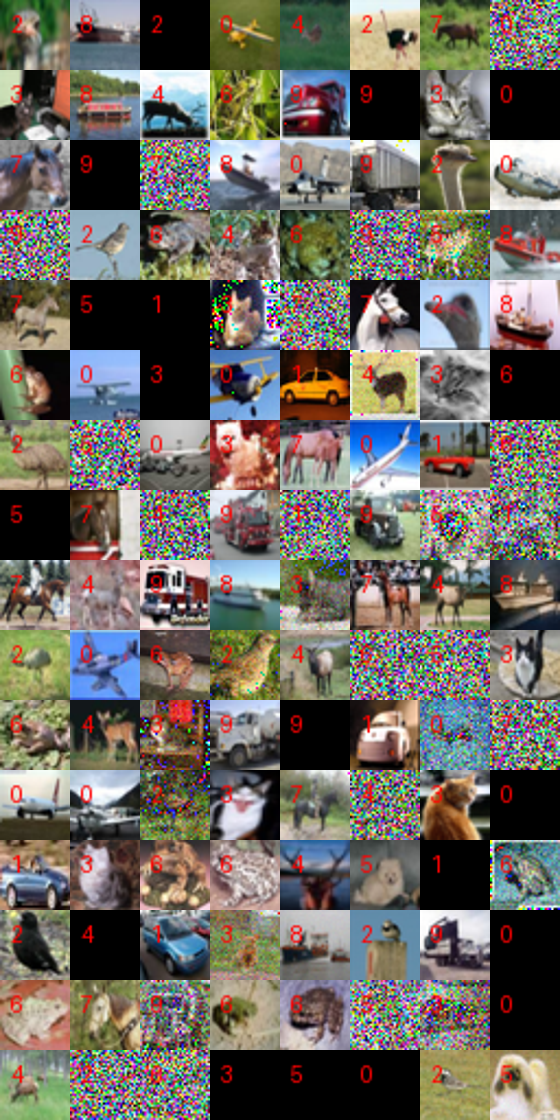

In [9]:
make_image_grid(pil_images, 16, 8, resize=70)

In [10]:
# Okay, immediately i see two problems:
# 1. Lots of images are basically 0.
# 2. Bunch of images are pure noise
# 3. some images have some random noise


# Step 1.
# A. Look at the distribution of images that have 0 and super high norm - norm measures for magnitude
# B. Look at the spread of the distribution, measured by variance. Might remove samples that have super high spread. Do it per class tho.

# Step 2.
# A. Remove all images with low and high norm
# B. Remove all duplicate images


# Step 3.
# Evaluation - use ECE to see how confident model predictions are relative to it's actual accuracy
# Label noise - is there label discrepency? If so, we may have to shift labels to the majority label (times it's corresponding weight)

In [11]:
def analyze_statistics(batch):
  images: torch.Tensor = batch['pixel_values'] if isinstance(batch, dict) else batch[0]  # batch_size, 3, 32, 32
  labels: torch.Tensor = batch['labels'] if isinstance(batch, dict) else batch[1] # batch_size

  norms = torch.norm(images, p=2, dim=(1, 2, 3))

  median_norm = norms.median().item()

  # Visualize samples with low, medium, and super high norms
  sorted_indices = norms.argsort()
  # Get images corresponding to low, medium, and high norms
  images_with_low_norm = [transforms.ToPILImage()(img) for img in images[sorted_indices[:10]]]
  images_with_high_norm = [transforms.ToPILImage()(img) for img in images[sorted_indices[-10:]]]
  images_with_median_norm = [transforms.ToPILImage()(img) for img in images[sorted_indices[len(sorted_indices)//2 - 5:len(sorted_indices)//2 + 5]]]

  q1, q3 = torch.quantile(norms, torch.tensor([0.25, 0.75]))

  h = make_image_grid(images_with_high_norm, 2, 5, resize=60)

  l = make_image_grid(images_with_low_norm, 2, 5, resize=60)

  m = make_image_grid(images_with_median_norm, 2, 5, resize=60)

  plt.figure()
  plt.title(f"Analyzing distribution with median {round(median_norm, 2)}")
  plt.axvline(x=q1, color='r', linestyle='--', label='Q1')
  plt.axvline(x=q3, color='r', linestyle='--', label='Q3')
  plt.hist(norms, bins=10)
  plt.ylabel("Frequency")
  plt.xlabel("Norm")
  plt.legend()
  plt.plot()


  # Let's also visualize the variance of the dataset
  vars = torch.var(images, dim=(1, 2, 3)) # per image variance
  plt.figure()
  plt.title(f"Analyzing Variance with median {round(vars.median().item(), 2)}")
  plt.hist(vars, bins=10)
  plt.ylabel("Frequency")
  plt.xlabel("Variance")
  plt.plot()
  return h, l, m


def prune_images(batch):
  # okay, so low norm

  images: torch.Tensor = batch['pixel_values']  # batch_size, 3, 32, 32
  labels: torch.Tensor = batch['labels'] # batch_size

  norms = torch.norm(images, p=2, dim=(1, 2, 3))

  # Remove all samples that are less than 1 norm. Remove all samples that are in the 90th percentile
  low = torch.quantile(norms, 0.25).item() # Q1
  high = torch.quantile(norms, 0.75).item()  # Q3

  prune_idx = torch.where((low < norms) & (norms < high))[0]


  return {
      'pixel_values': images[prune_idx],
      'labels': labels[prune_idx]
  }


def prune_dataloader(dataloader, func):
  ds = defaultdict(list)
  for batch in tqdm(dataloader):
    out = func(batch)

    for k, v in out.items():
      ds[k].append(v)

  ds['pixel_values'] = torch.cat(ds['pixel_values'])
  ds['labels'] = torch.cat(ds['labels'])
  print(f"Dataset kept: {len(ds['pixel_values']) / len(dataloader.dataset)}")

  if 'number_of_incorrect_labels' in ds:
    print('total incorrect labels', np.sum(ds['number_of_incorrect_labels']))

  ds = TensorDataset(ds['pixel_values'], ds['labels'])

  return DataLoader(ds, batch_size=128, shuffle=True)

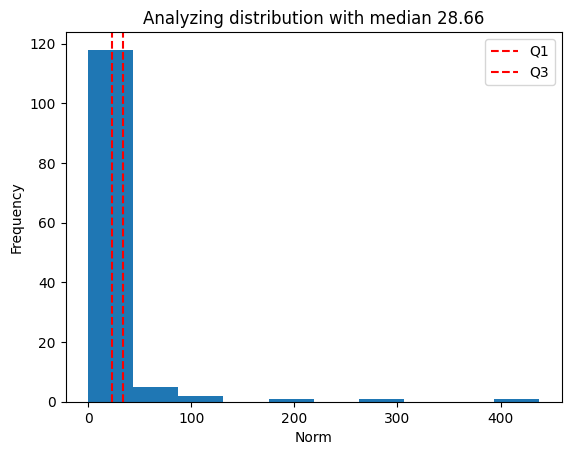

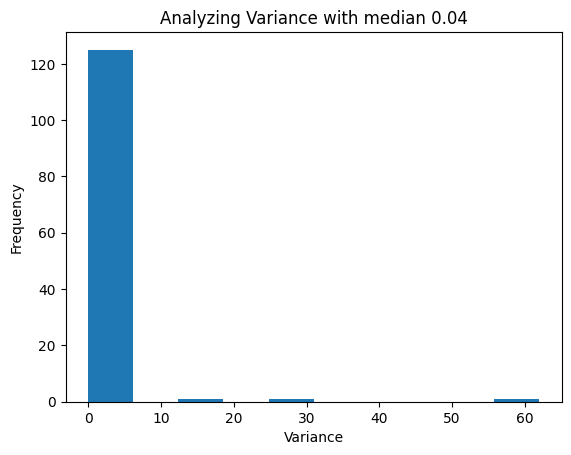

In [12]:
h, l, m = analyze_statistics(batch)

100%|██████████| 586/586 [00:17<00:00, 33.30it/s]


Dataset kept: 0.4987333333333333


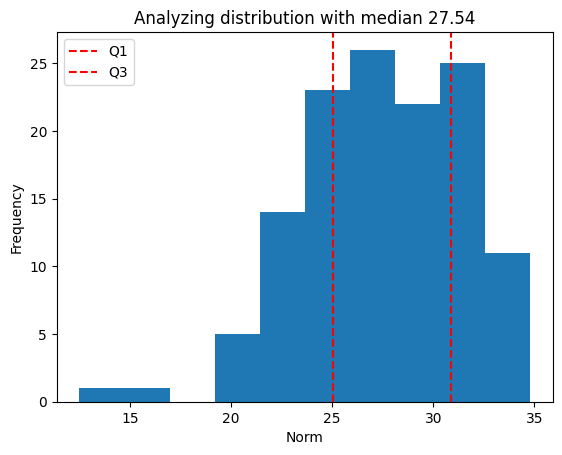

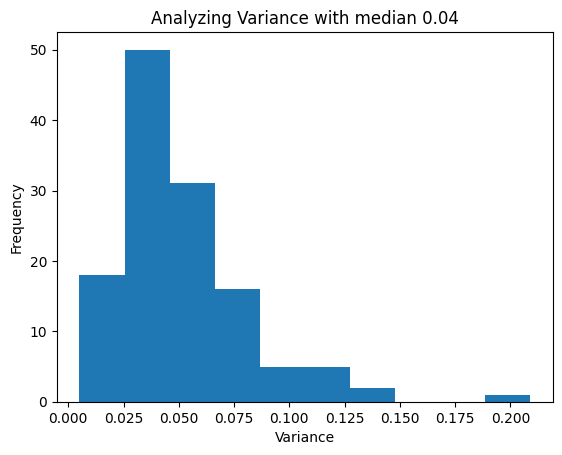

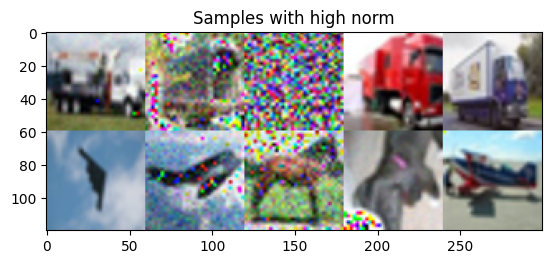

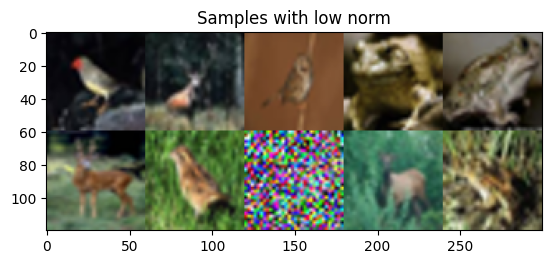

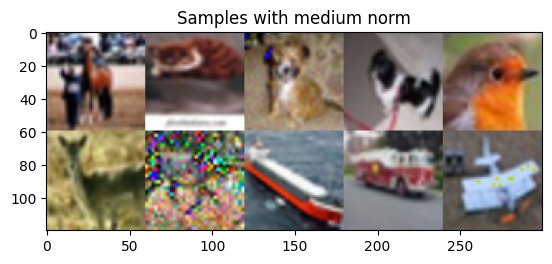

In [13]:
pruned_dl = prune_dataloader(corrupted_train_loader, prune_images)

# Visualize
batch = next(iter(pruned_dl))
h, l, m = analyze_statistics(batch)

plt.figure()
plt.title("Samples with high norm")
plt.imshow(h)
plt.figure()
plt.title("Samples with low norm")
plt.imshow(l)
plt.figure()
plt.title("Samples with medium norm")
plt.imshow(m)

In [14]:
out_v1 = train_model(pruned_dl, 5)

100%|██████████| 79/79 [00:01<00:00, 72.22it/s]


[Epoch 1/5] Train Loss: 1.981, Train Score: 0.270 | Test Loss: 1.816, Test Score: 0.323


100%|██████████| 79/79 [00:01<00:00, 72.56it/s]


[Epoch 2/5] Train Loss: 1.887, Train Score: 0.325 | Test Loss: 1.710, Test Score: 0.384


100%|██████████| 79/79 [00:01<00:00, 73.16it/s]


[Epoch 3/5] Train Loss: 1.856, Train Score: 0.298 | Test Loss: 1.659, Test Score: 0.395


100%|██████████| 79/79 [00:01<00:00, 72.54it/s]


[Epoch 4/5] Train Loss: 1.889, Train Score: 0.306 | Test Loss: 1.708, Test Score: 0.388


100%|██████████| 79/79 [00:01<00:00, 73.57it/s]

[Epoch 5/5] Train Loss: 1.787, Train Score: 0.363 | Test Loss: 1.571, Test Score: 0.439


In [15]:
# Last strategy of improving performance. Nearest neighbor approach for de-duplication

def featurize(samples):
  return F.interpolate(samples.mean(1, keepdim=True), size=(4, 4)).flatten(1)

def distance(samples):
  # cosine similarity
  x = samples / samples.norm(dim=-1, keepdim=True) # batch_size, d_embed
  return x @ x.T # batch_size x batch_size

def de_dup(batch, threshold:float=0.9): # higher threshold keeps more and more similar images

  images = batch['pixel_values'] - CIFAR10_MEAN if isinstance(batch, dict) else batch[0]
  labels = batch['labels'] if isinstance(batch, dict) else batch[1]

  embeddings = featurize(images)

  pruned_idx = set()

  number_of_incorrect_labels = 0

  # for each sample in the batch, identify the k most similar images and discard them all if they're below a certain threshold
  sim_matrix:torch.Tensor = distance(embeddings)
  sim_matrix.fill_diagonal_(-1.0)
  # columns with the highest score to sim_matrix[i] and under a certain threshold are sus and should be removed
  for i in range(len(images)):
    if i in pruned_idx:
      continue

    # The higher the score, the more similar the image
    val, idx = torch.topk(sim_matrix[i], k=min(15, len(sim_matrix)), largest=True)
    idx = idx[val > threshold]

    # Label discrepency measure
    if len(idx) == 0:
      continue

    joint_labels = torch.cat([labels[idx], labels[i].view(-1)])
    majority_label = torch.bincount(joint_labels).argmax()
    if labels[i].item() != majority_label:
      number_of_incorrect_labels += 1

    # At this point we have found samples that are very similar to the original image and would like to prune them out
    for j in idx:
      if j.item() not in pruned_idx:
        pruned_idx.add(j.item())

  pruned_idx = torch.from_numpy(np.array(list(pruned_idx)).astype(np.uint32)).long()
  mask = ~torch.isin(torch.arange(len(images)), pruned_idx)
  keep_idx = torch.where(mask)[0]

  return {'pixel_values': images[keep_idx], 'labels': labels[keep_idx], 'number_of_incorrect_labels': number_of_incorrect_labels}

100%|██████████| 293/293 [00:01<00:00, 154.04it/s]


Dataset kept: 0.2889720625584815
total incorrect labels 6899
Num samples in original dataset: 37405	Num samples in pruned dataset: 10809


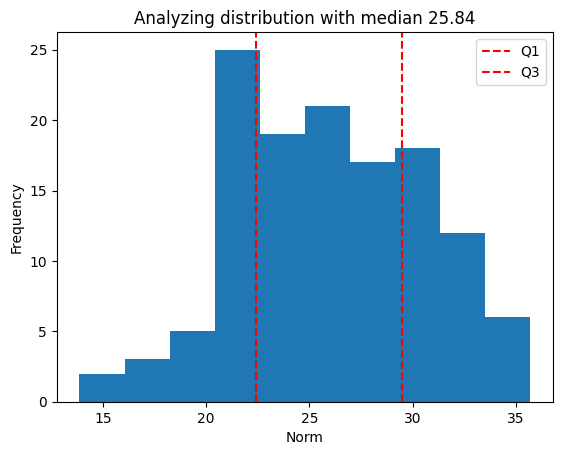

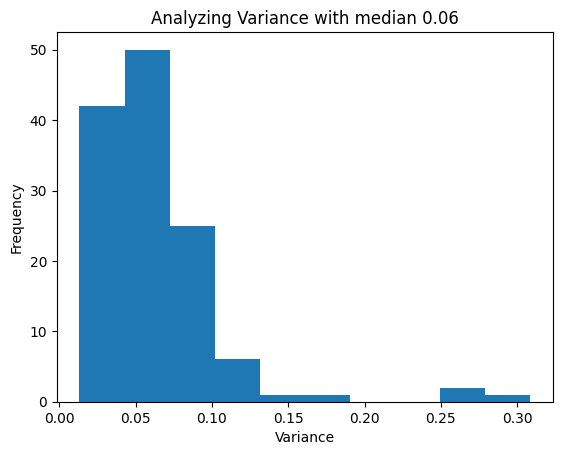

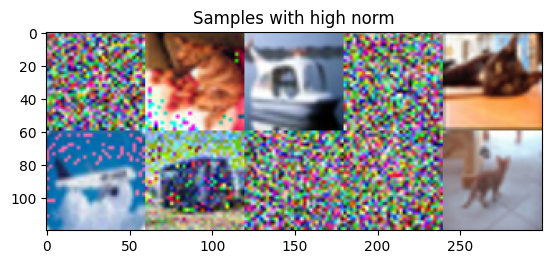

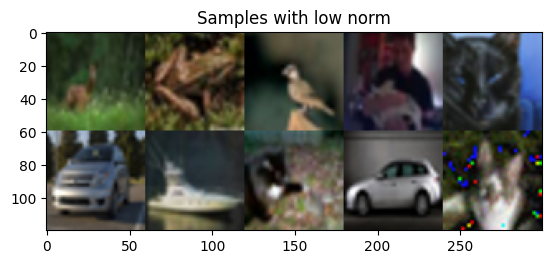

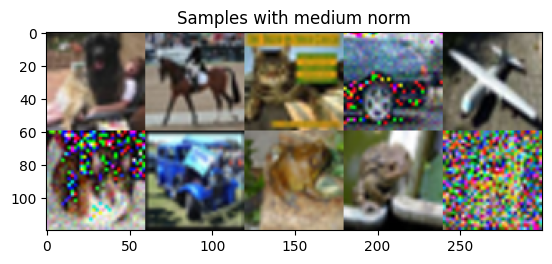

In [16]:
pruned_v2_dl = prune_dataloader(pruned_dl, de_dup)
print(f"Num samples in original dataset: {len(pruned_dl.dataset)}\tNum samples in pruned dataset: {len(pruned_v2_dl.dataset)}")

# Visualize
batch = next(iter(pruned_v2_dl))
h, l, m = analyze_statistics(batch)

plt.figure()
plt.title("Samples with high norm")
plt.imshow(h)
plt.figure()
plt.title("Samples with low norm")
plt.imshow(l)
plt.figure()
plt.title("Samples with medium norm")
plt.imshow(m)

In [17]:
out_v2 = train_model(pruned_v2_dl, num_epochs=5) # final model training with low and high image norm pruned out plus de-dup

100%|██████████| 79/79 [00:01<00:00, 72.95it/s]


[Epoch 1/5] Train Loss: 1.947, Train Score: 0.301 | Test Loss: 1.777, Test Score: 0.372


100%|██████████| 79/79 [00:01<00:00, 72.66it/s]


[Epoch 2/5] Train Loss: 1.938, Train Score: 0.284 | Test Loss: 1.752, Test Score: 0.356


100%|██████████| 79/79 [00:01<00:00, 73.01it/s]


[Epoch 3/5] Train Loss: 1.856, Train Score: 0.328 | Test Loss: 1.654, Test Score: 0.416


100%|██████████| 79/79 [00:01<00:00, 73.23it/s]


[Epoch 4/5] Train Loss: 1.867, Train Score: 0.318 | Test Loss: 1.678, Test Score: 0.396


100%|██████████| 79/79 [00:01<00:00, 73.39it/s]

[Epoch 5/5] Train Loss: 1.749, Train Score: 0.385 | Test Loss: 1.505, Test Score: 0.490


In [18]:
def calibration(logits, y_true, bin_count: int = 10):
  '''
  Implements ECE calibration technique
  Algorithm:
  1. Compute confidence (probs) and correct predictions for each item in the batch
  2. Create n bins to discritize your model predictions into them.
  Every bin represents a confidence bound, i.e. how many correct predictions were in that bin?
  3. For each bin, compute:
   1) Accuracy - proportion of correct predictions in that bin
   2) Conf - average confidence for that bin
  4. Apply the ECE formula for each bin: |conf - acc| * bin_size / total_size
  The total sum represents the error, expected calibration error.
  '''
  probs = torch.softmax(logits, dim=-1)
  conf, preds = probs.max(dim=1) # torch.max returns both the argmax and the value corresponding to that. output shape = batch_size

  correct = 1 * (y_true == preds)

  bins = torch.linspace(0, 1, bin_count + 1)

  total_ece = 0.0
  individual_confidence_in_bin = []
  individual_accuracy_in_bin = []

  for i in range(bin_count):
    mask = (conf >= bins[i]) & (conf < bins[i + 1])

    if mask.sum().item() == 0: # no predictions in bin
      individual_accuracy_in_bin.append(0.0)
      individual_confidence_in_bin.append(0.0)
      continue

    average_accuracy_in_bin = correct[mask].float().mean()
    average_confidence_in_bin = conf[mask].float().mean()

    # Update statistics
    # ECE = abs(bin accuracy - bin confidence) * (num elements in bin / batch_size)
    bin_ece = torch.abs(average_accuracy_in_bin - average_confidence_in_bin) * mask.sum().item() / len(conf)
    individual_accuracy_in_bin.append(average_accuracy_in_bin.item())
    individual_confidence_in_bin.append(average_confidence_in_bin.item())
    total_ece += bin_ece.item()

  return total_ece, individual_accuracy_in_bin, individual_confidence_in_bin


def run_ece(dataloader, results, num_classes:int = 10):
  f1, loss, vals = validate(results['model'], dataloader, results['criterion'])
  cm, all_logits, all_pred, all_true = vals

  num_batches = len(all_logits)

  total_acc = np.zeros(num_classes)
  total_conf = np.zeros(num_classes)
  mean_error = 0.0
  for i in tqdm(range(num_batches)):
    err, acc, conf = calibration(all_logits[i], all_true[i])
    mean_error += err

    total_acc += np.array(acc)
    total_conf += np.array(conf)

  return {'average_error': mean_error / num_batches, 'total_acc': total_acc / num_batches, 'total_conf': total_conf / num_batches}


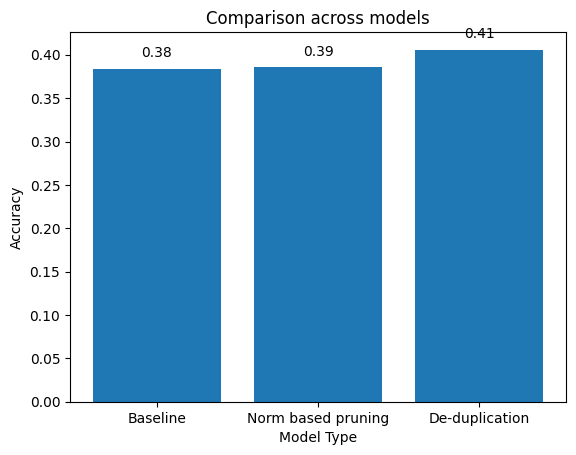

In [19]:
# Comparison across models
baseline_score = np.mean(out_baseline['results']['test_score'])
vanilla_pruning_score = np.mean(out_v1['results']['test_score'])
de_dup_score = np.mean(out_v2['results']['test_score'])

plt.title('Comparison across models')
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.bar(np.arange(3), [baseline_score, vanilla_pruning_score, de_dup_score])
plt.xticks(np.arange(3), ['Baseline', 'Norm based pruning', 'De-duplication'])

for i, v in enumerate([baseline_score, vanilla_pruning_score, de_dup_score]):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

plt.show()

100%|██████████| 79/79 [00:00<00:00, 884.33it/s]


Average Error: 0.104


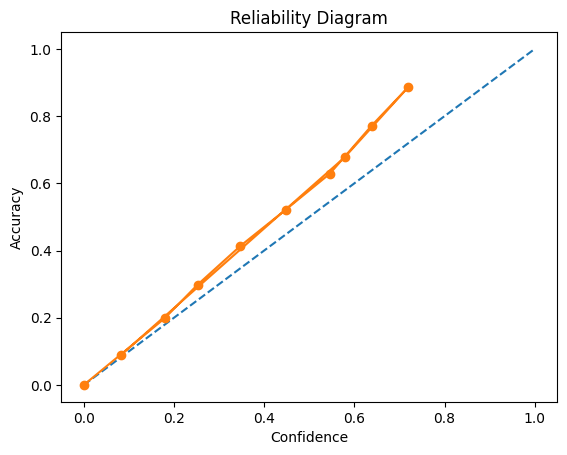

In [20]:
results = run_ece(test_loader, out_v1)
print(f"Average Error: {round(results['average_error'], 3)}")
plt.figure()
plt.plot([0,1],[0,1], linestyle='--', label='Expected')
plt.plot(results['total_conf'], results['total_acc'], marker='o', label='True')
plt.xlabel("Confidence")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.show()